In [34]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import numpy as np
import matplotlib.pyplot as plt
import logging
import os
import time
import pandas as pd

dimensions = 4
iterations = 300
kappa = 0.1

random_seed = 50

csv_path = '/Users/davidcoope/Desktop/BayesianOptimiser/WeldedBeam/PBOResults.csv'
log_path = '/Users/davidcoope/Desktop/BayesianOptimiser/WeldedBeam/PBOlog.log'

# Check if the csv file exists and delete it if it does
if os.path.exists(csv_path):
    os.remove(csv_path)

In [35]:
def WeldedBeam(X):
    # Calculate the objective function value
    y = 1.10471 * X[0]**2 * X[1] + 0.04811 * X[2] * X[3] * (X[1] + 14)
    
    # Calculate constraint components
    tau1 = 6000 / (np.sqrt(2) * X[0] * X[1])
    tau2 = 504000 / (X[2]**2 * X[3])
    tau = np.sqrt(tau1**2 + tau2**2 + (X[1] * tau1 * tau2) / np.sqrt(0.25 * (X[1]**2) + (X[0] + X[2])**2))
    
    sigma = 504000 / (X[2]**2 * X[3])
    
    Pc = 64746.022 * (1 - 0.0282346 * X[2]) * X[2] * X[3]**3
    
    delta = 2.1952 / (X[2] * X[3])
    
    # Add the constraints
    constraint = (
        (tau - 13000 > 0) or
        (sigma - 30000 > 0) or
        (X[0] - X[3] > 0) or
        (6000 - Pc > 0) or
        (delta - 0.25 > 0)
    )
    
    if constraint:
        y = 2000  # Apply penalty for constraint violation
    
    # Make function negative to find the minimum
    y = -y
    
    return y

bounds = {'x[0]':(0.125,10),'x[2]':(0.125,10),'x[3]':(0.1,10),'x[4]':(0.1,10)}
ObjectiveFunction = WeldedBeam

In [36]:
def WriteOutput(csv_file, raw_X, raw_Y, iteration):
    """
    Function to write results from each simulation to csv file.

    Parameters:
    csv_file (string): path to the csv file
    raw_X (2d array): the whole batch of input parameters
    raw_Y (2d array): the batch of output values
    """

    iteration_numbers = np.full(len(raw_X), iteration)
    simulation_numbers = range(0, len(raw_X))

    data = {
        'Iteration': np.array(iteration_numbers),
        'Simulation': np.array(simulation_numbers),
        'Result': raw_Y[:],
    }

    # Add raw_X values with column names
    for i in range(np.shape(raw_X)[1]):
        data[f'X{i}'] = raw_X[:, i]

    df = pd.DataFrame(data)

    # Check the output file exists, if not create it and write the headers of each column. Otherwise, append the new row to the file
    if not os.path.isfile(csv_file):
        df.to_csv(csv_file, index=False)
    else:
        df.to_csv(csv_file, mode='a', header=False, index=False)

In [37]:
# Check if the log file exists and delete it if it does
if os.path.exists(log_path):
    os.remove(log_path)

# Setup logger and set level to INFO
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Setup Log_handler - set mode to 'w' to write
log_handler = logging.FileHandler(log_path, mode='w')
log_handler.setLevel(logging.INFO)

# Define the log format (preamble before your message is displayed)
log_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
log_handler.setFormatter(log_format)

# add the handler to the logger object so you can start writing to the log file
logger.addHandler(log_handler)

In [38]:
Optimiser = BayesianOptimization(f=None, pbounds=bounds, verbose=2, random_state=1)

random_counter = 0
np.random.seed(random_seed)

for j in range(iterations): 

    Optimiser.set_bounds(bounds)
   
    start_time = time.time()
    raw_X = []
    logger.info(f'Getting X value for iteration {j}')

    if j == 0:
        next_point = np.array([np.random.uniform(low, high) for (low, high) in bounds.values()])
        logger.info(f'Getting X value for iteration {j}. This is the random iteration.')
        raw_X.append(list(next_point))

    else:
        acquisition_function = UtilityFunction(kind="ucb", kappa=kappa)
        logger.info(f'Getting X value for iteration {j}')
        next_point = Optimiser.suggest(acquisition_function)

        #Ensure the point is not a duplicate
        counter = 0
        while list(next_point.values()) in raw_X:
            logger.info(f'Point already exists...recalculating X values. Attempt {counter+1}')
            next_point = Optimiser.suggest(acquisition_function)
            counter += 1
            if counter > 9:
                random_counter += 1
                logger.info(f'Random X values being used. This has been done {random_counter+1} times so far')
                next_point = {f'x[{i}]': np.random.uniform(bounds[f'x[{i}]'][0], bounds[f'x[{i}]'][1]) for i in range(1, dimensions+1)}
                break
        raw_X.append(list(next_point.values()))

    end_time = time.time()
    logger.info(f'The time taken to get X value for iteration {j} was {end_time-start_time}')
    logger.info('')

    raw_Y = []
    target = ObjectiveFunction(raw_X[0])
    Optimiser.register(params=raw_X[0], target=target)
    raw_Y.append(target)

    raw_X = np.array(raw_X)
    raw_Y = np.array(raw_Y)

    WriteOutput(csv_path, raw_X, raw_Y, j)
    # Read the csv file into a pandas DataFrame
    df = pd.read_csv(csv_path)
    # Extract the Y data from the csv file
    Y_data = df['Result'].values
    # Calculate the current number of iterations at the time of making the graph
    Current_Number_Iterations = int(len(Y_data))
    # Extract the X data from the csv file
    X_data = np.zeros((Current_Number_Iterations, dimensions))
    for i in range(Current_Number_Iterations):
        for k in range(dimensions):
            X_data[i][k] = df[f'X{k}'][i]

    logger.info(f'So far, the best result has been {Optimiser.max}')


logger.info(Optimiser.max)
logger.info(f'Random x values were used {random_counter} times')

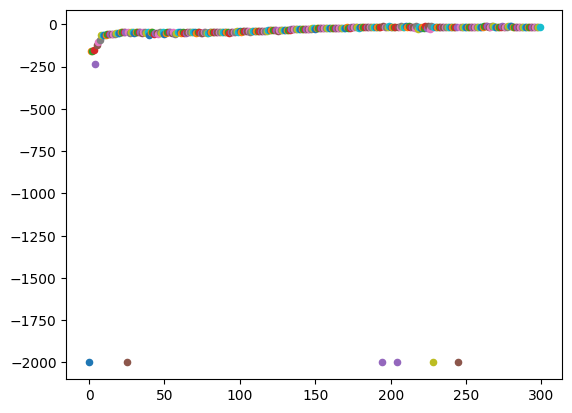

In [39]:
Iteration_Y = np.split(Y_data,iterations)

np.shape(Iteration_Y[0])

for i in range(iterations):
    plt.scatter(range(i*len(Iteration_Y[i]),(i+1)*len(Iteration_Y[i])),Iteration_Y[i], s=20)


In [40]:
print(Optimiser.max)

{'target': np.float64(-12.548722811202005), 'params': {'x[0]': np.float64(3.037553022939493), 'x[2]': np.float64(0.125), 'x[3]': np.float64(5.220992802716301), 'x[4]': np.float64(3.177787330041501)}}
